# MNIST  HANDWRITTEN  DIGIT  CLASSIFICATION

MNIST handwritten digit classification is one of the most popular and fundamental deep learning problem.
MNIST stands for Modified National Institute of Standards and Technology dataset.
In this article, you will use Convolutional Neural Network(CNN) to form MNIST model which recognizes digit.

It is a dataset which consists of 28 X 28 pixels grayscale images of handwritten single digits between 0 and 9. 

In [5]:
import tensorflow as tf
print(tf.__version__)         # To check tensorflow version

2.3.0


Make sure that you are using tensorflow 2.x i.e, 2.0.0 or above

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Each pixel is characterised by its (x, y) coordinates and its value. Digital images are characterised by matrix size, 
pixel depth and resolution. The matrix size is determined from the number of the columns (m) and the number of rows (n) of the
image matrix (m × n).

2D or grayscale images are represented as (m, n). It has only single Channel
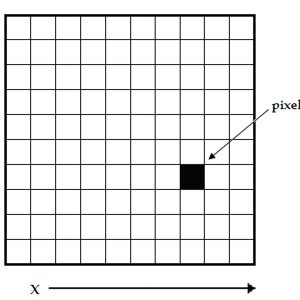

whereas 3D images are represented as (m, n, 3) where 3 is the number of channels which is reprsented by RGB(Red Green Blue) colour
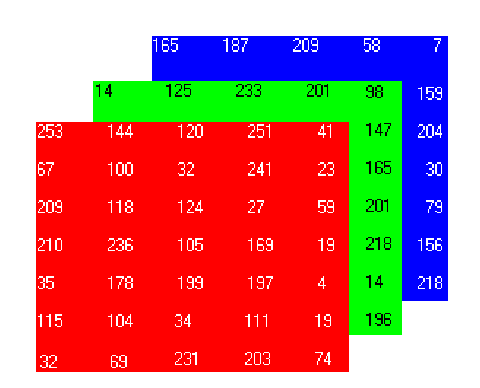

MNIST dataset consists of 42000 training and 28000 testing grayscale images.
Download dataset from the following link https://www.kaggle.com/c/digit-recognizer/data

This dataset is present in the CSV format so preprocess it to convert into matrix form which would represent image.
Eaxh row of the dataset represents single image with corresponding label. We want each image of shape 28X28 pixel.

In [8]:
# we want 28X28 pixel image
pixels = 28  

In [9]:
def line_2_img(img_dataset, csv_file):
    
    # iterate through each rows of the csv file
    for idx,line in enumerate(csv_file.iterrows()):
        
        # getting single row
        img = csv_file.iloc[idx]
        
        # converting row into numpy array
        img = np.array(img)
        
        # converting 1D numpy array into 2D numpy array
        img= np.array_split(img, 28)
        
        # string into final dataset at corresponding index
        img_dataset[idx, :, :] = img
        
    return img_dataset

In [10]:
def get_file(train_file, test_file):
    
    # loading train dataset CSV format
    train_img_df = pd.read_csv(train_file)
    
    # training dataset label
    train_label = train_img_df['label']  
    
    # dropping label from tarining dataframe because we have created seperate dataframe for that
    train_img_df.drop('label', axis=1, inplace=True) 
    
    # loading test dataset CSV format
    test_img_df = pd.read_csv(test_file)
    
    # length of train dataset
    train_length = train_img_df.shape[0]
    
    # creating numpy array for training image datatset initially filled with zero
    train_img = np.zeros((train_length, 28, 28))
    
    # length of test dataset
    test_length = test_img_df.shape[0]
    
    # creating numpy array for testing image datatset initially filled with zero
    test_img = np.zeros((test_length, 28, 28))
    
    # getting training image dataset into the array format
    train_img = line_2_img(train_img, train_img_df)
    
    # getting test image dataset into the array format
    test_img = line_2_img(test_img, test_img_df)
    
    return train_img, train_label, test_img

In [11]:
# training CSV dataset path
train_dir = '/content/gdrive/My Drive/digit-recognizer/train_digit.csv'

# testing CSV dataset path
test_dir = '/content/gdrive/My Drive/digit-recognizer/test_digit.csv'

In [12]:
# converting CSV file into 2D image dataset
train, train_label, test = get_file(train_dir, test_dir)

In [13]:
print('Train : {},  Test : {},  Training_Label : {}'.format(train.shape, test.shape, train_label.shape))

Train : (42000, 28, 28),  Test : (28000, 28, 28),  Training_Label : (42000,)


Given below are some of the training images with corresponding label

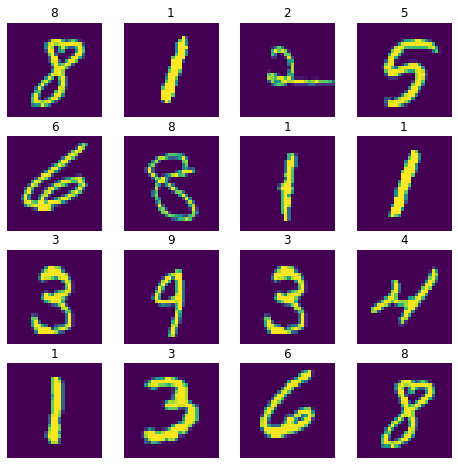

In [14]:
# printing few training images with corresponding label
fig = plt.figure(figsize=(8, 8))

columns = 4
rows = 4
axes = []

# printing 16 training images
for i in range(1, columns*rows +1):
    idx = np.random.randint(1, 100)
    img = train[idx]
    axes.append(fig.add_subplot(rows, columns, i))
    subplot_title = train_label[idx]
    axes[-1].set_title(subplot_title)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    
plt.show()

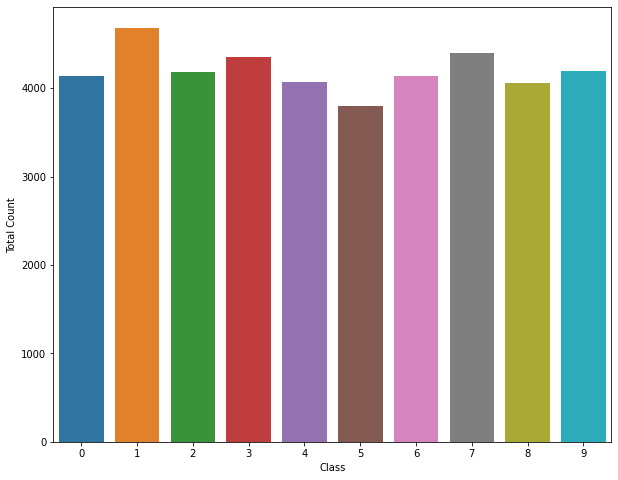

In [15]:
# plotting number of labels of each class
import seaborn as sns

train_lbl = pd.DataFrame(train_label)
train_lbl.columns = ['label']
sns.countplot(x = "label", data = train_lbl)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xlabel("Class")
plt.ylabel("Total Count")
plt.show()

In [16]:
train_label = np.array(train_label)

# adding extra dimension to train and test image this extra dimension represents number of channel of grayscale image
train = np.expand_dims(train, axis=3)
test = np.expand_dims(test, axis=3)

In [17]:
# converting 1D array to 2D array
train_label = np.expand_dims(train_label, axis=1)

Dividing train dataset into train and vaildation set of size ratio 90:10

In [18]:
train_size = int(train.shape[0] * 0.9)

train_img, valid_img = train[ : train_size], train[train_size : ]
train_label, valid_label = train_label[ : train_size], train_label[train_size : ]

Generate batches of tensor image data with real-time data augmentation.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                       # normalizing each pixels of image
    rotation_range=30,                    #  Integer Degree range for random rotations.
    width_shift_range=0.2,                
    height_shift_range=0.2,
    shear_range=0.2,                      # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,                       # Range for random zoom 
    fill_mode='nearest',                  #  Points outside the boundaries of the input are filled 
    horizontal_flip=False,                #  Boolean randomly flip inputs horizontally.
    vertical_flip = False                 #  Boolean randomly flip inputs vertically
    )

In [21]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

Training CNN model to classify each image as one of the label from 0 - 9

In [22]:
# Loading Libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dropout,Dense
from tensorflow.keras.optimizers import RMSprop

In [23]:
# building model
model = tf.keras.Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1),  padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    Flatten(),

    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

In [24]:
# model compile
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

In [25]:
# model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0

In [26]:
# training CNN model over 15 epochs
train_generator = train_datagen.flow(train_img, train_label, batch_size=32)
validation_generator = validation_datagen.flow(valid_img, valid_label, batch_size=32)

history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
1182/1182 [==============================] - 14s 12ms/step - loss: 1.2145 - acc: 0.1407 - val_loss: 0.2311 - val_acc: 0.1131
Epoch 2/15
1182/1182 [==============================] - 13s 11ms/step - loss: 0.4801 - acc: 0.0966 - val_loss: 0.1505 - val_acc: 0.1088
Epoch 3/15
1182/1182 [==============================] - 14s 11ms/step - loss: 0.3138 - acc: 0.0975 - val_loss: 0.0860 - val_acc: 0.1081
Epoch 4/15
1182/1182 [==============================] - 14s 12ms/step - loss: 0.2418 - acc: 0.0973 - val_loss: 0.0653 - val_acc: 0.1083
Epoch 5/15
1182/1182 [==============================] - 14s 12ms/step - loss: 0.1896 - acc: 0.0976 - val_loss: 0.0627 - val_acc: 0.1074
Epoch 6/15
1182/1182 [==============================] - 13s 11ms/step - loss: 0.1637 - acc: 0.0976 - val_loss: 0.0472 - val_acc: 0.1083
Epoch 7/15
1182/1182 [==============================] - 13s 11ms/step - loss: 0.1456 - acc: 0.0975 - val_los

Plotting accuracy vs epochs to visualize model performance

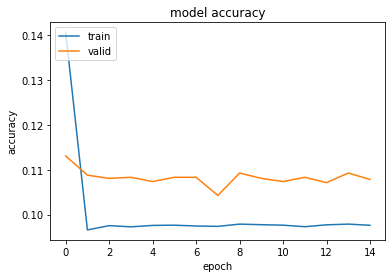

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Plotting loss vs epochs to visualize model performance

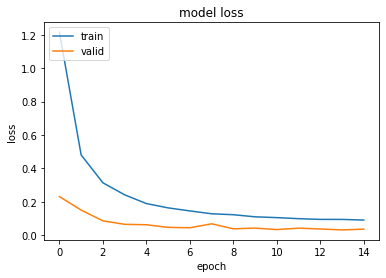

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Evaluatiing given model over test dataset gives 98.89% accuracy 

Visualizing intermediate activations of each layer of CNN model

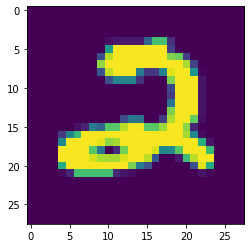

In [37]:
# visualizing each layer output based on below example
img_tensor = test[0]
img_tensor = img_tensor.reshape(28, 28)

plt.imshow(img_tensor)

In [41]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [43]:
from keras import models
# extracting output of each layer of model
layer_outputs = [layer.output for layer in model.layers] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor) 
print('Number of layers in the model : {}'.format(len(activations)))

Number of layers in the model : 13


In [45]:
# name of each layer
layer_names = [] 
  
for layer in model.layers: 
  layer_names.append(layer.name) 
print('Name of first 4 layers : {}'.format(layer_names[:4]))

Name of first 4 layers : ['conv2d', 'conv2d_1', 'max_pooling2d', 'dropout']


Activation of first layer

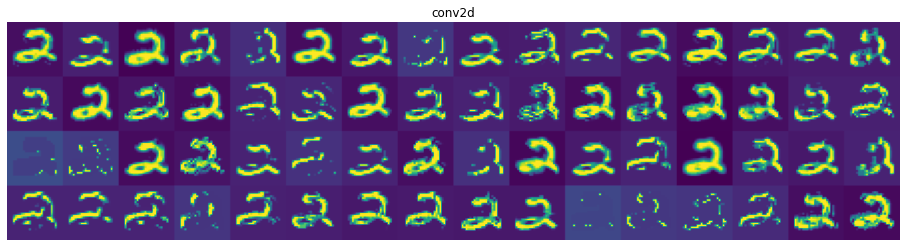

In [48]:
# number of images displaying in each row
images_per_row = 16

# first layer activation
first_layer_activation = activations[0] 

 # Number of features in the feature map
n_features = first_layer_activation.shape[-1]

 #The feature map has shape (1, size, size, n_features).
size = first_layer_activation.shape[1]

 # Tiles the activation channels in this matrix
n_rows = n_features // images_per_row
 
display_grid = np.zeros((size * n_rows, images_per_row * size))

for row_number in range(n_rows):
    for row in range(images_per_row):
        feature_n = row_number * images_per_row + row
        channel_image = first_layer_activation[0,:, :, feature_n]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128

        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[row_number * size : (row_number + 1) * size, # Displays the grid
                       row * size : (row + 1) * size ] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
plt.title(layer_names[0])
plt.grid(False)
plt.axis('off')
plt.imshow(display_grid, aspect='auto', cmap='viridis')

Similarly, you can get activation of other layers too.

**Browser Based Tensorflow.js model**

install   "  **!pip install tensorflowjs**  "   if not already installed

In [53]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 4.7MB/s 


In [54]:
import tensorflowjs as tfjs

Saving model into HDF5 format

In [56]:
model.save('/content/gdrive/My Drive/digit-recognizer/model_updt.h5')

Converting HDF5 model into tensorflowjs model format. After conversion download the files from output directory

In [57]:
# output directory
path = '/content/gdrive/My Drive/PROJECT'

tfjs.converters.save_keras_model(model, path)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


**HTML file**

---



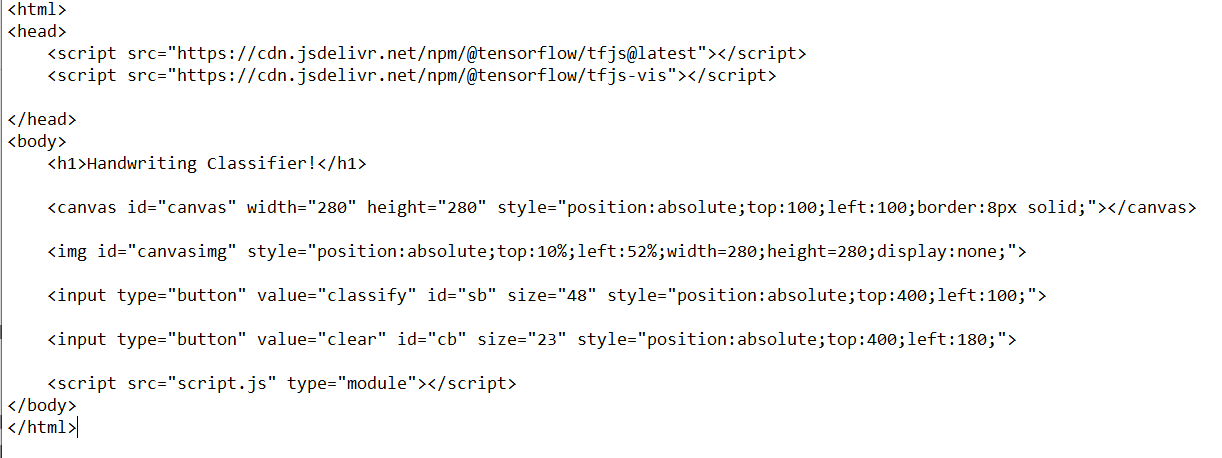

**JavaScript file**

---



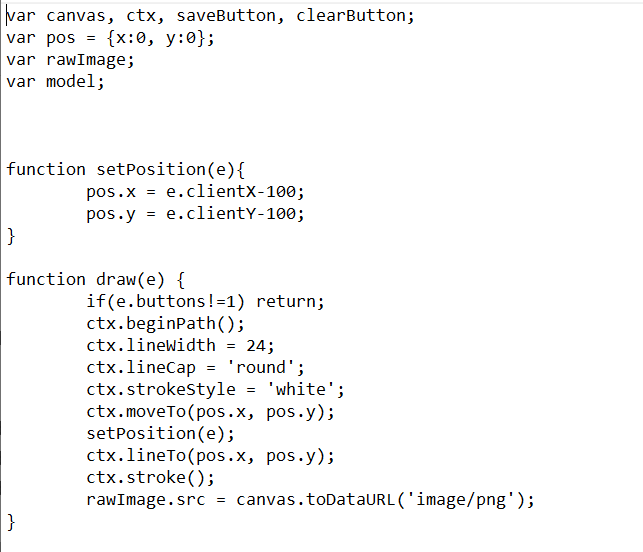

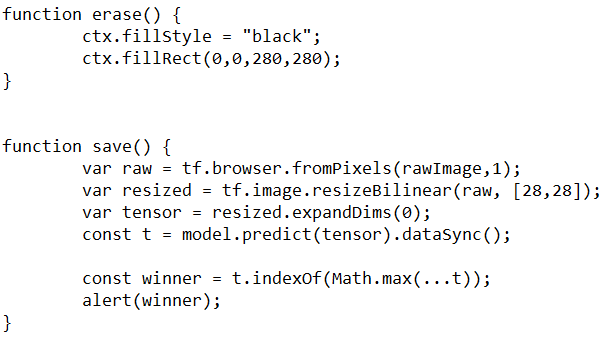

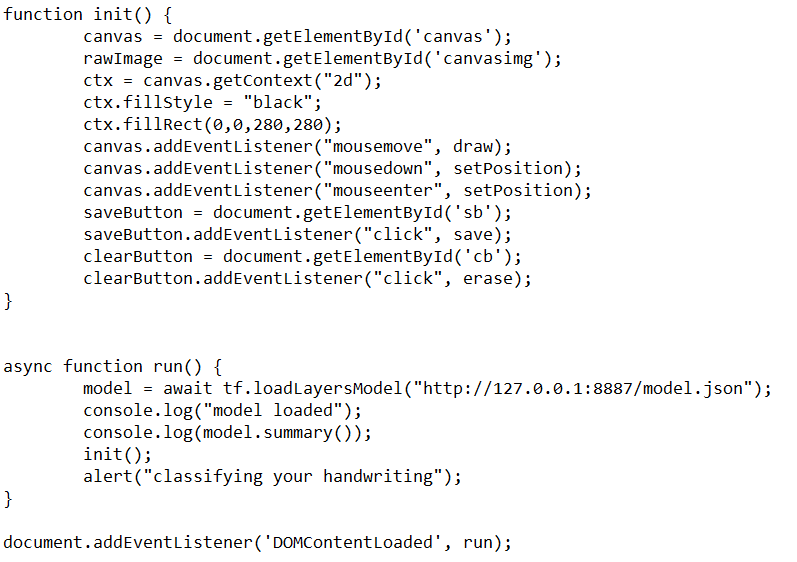

After creating HTML and JavaScript put all your **Files** into same directory 

**Files**
1.   HTML file
2.   JavaScript file
3.   Saved model files





To run project install : 


1.   Chrome
2.   Web Server for Chrome



To install chrome visit given link
https://www.google.com/chrome/

To install Web Server for Chrome visit given link
https://chrome.google.com/webstore/detail/web-server-for-chrome/ofhbbkphhbklhfoeikjpcbhemlocgigb?hl=en

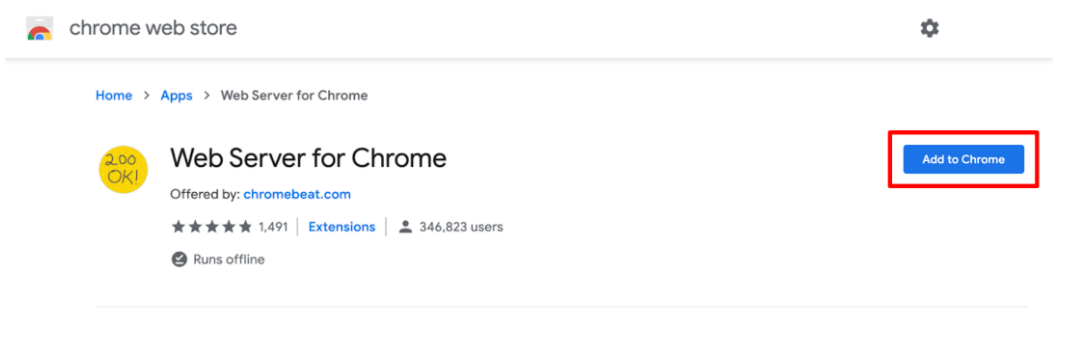

Click on the blue "Add to Chrome" button on the upper right-hand corner. The app will automatically be added to your Chrome Browser. You can find it under the chrome apps (chrome://apps/):

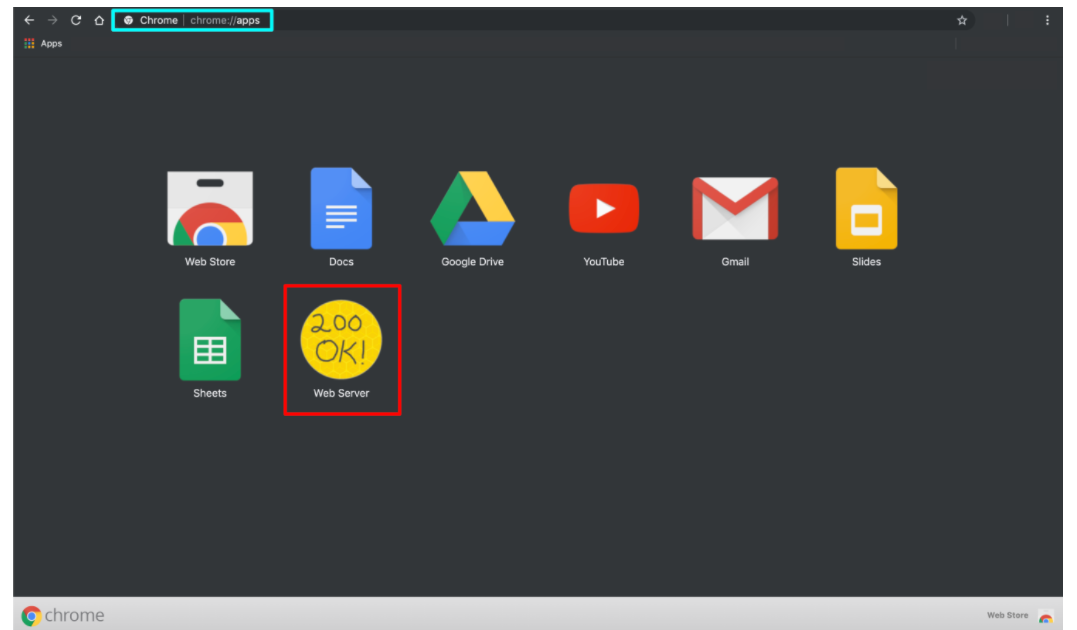

After successful installation 
Type "chrome://apps/" in your Chrome browser
Select Web Server Icon

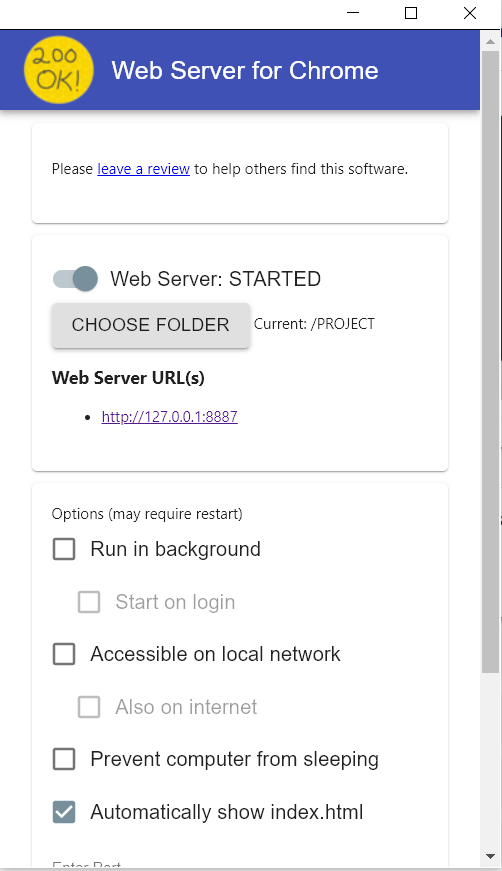

Select your project directory where all your files are stored and then click on "Web Server URL(s)" --> click on your html file 
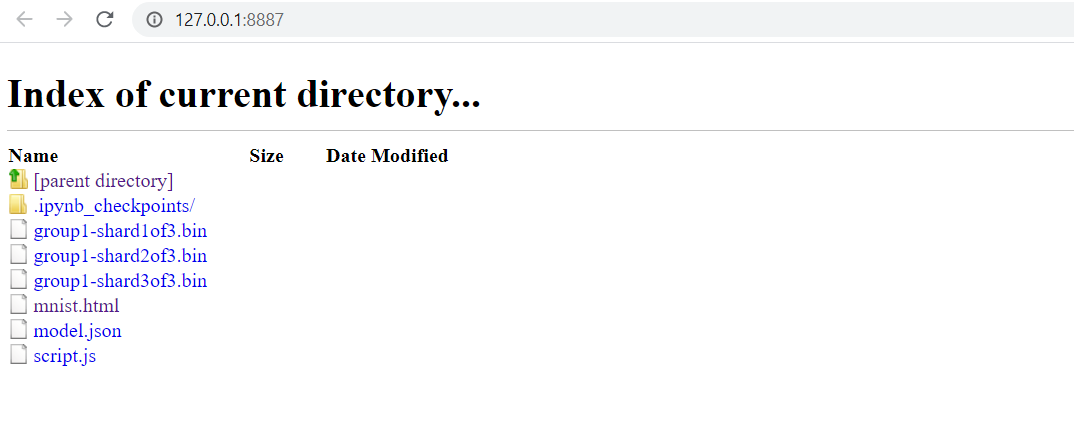

ScreenShots of my project
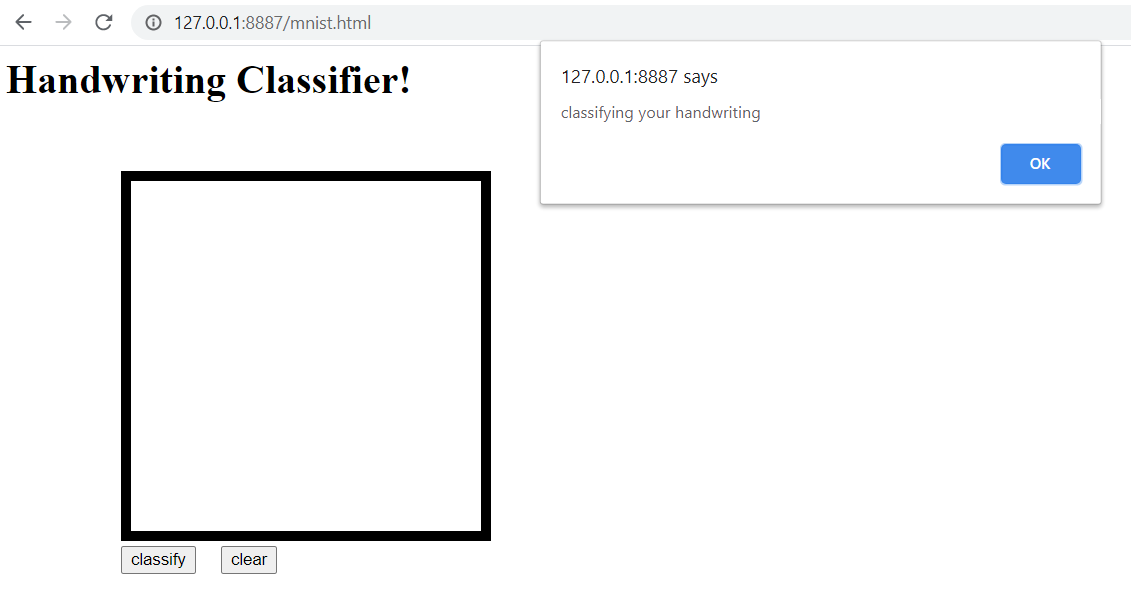

Open developer tools in your chrome browser 

Draw digit on the canvas  --> (click on button)classify --> (click on button)clear (to draw another digit) and 

---

repeat this process
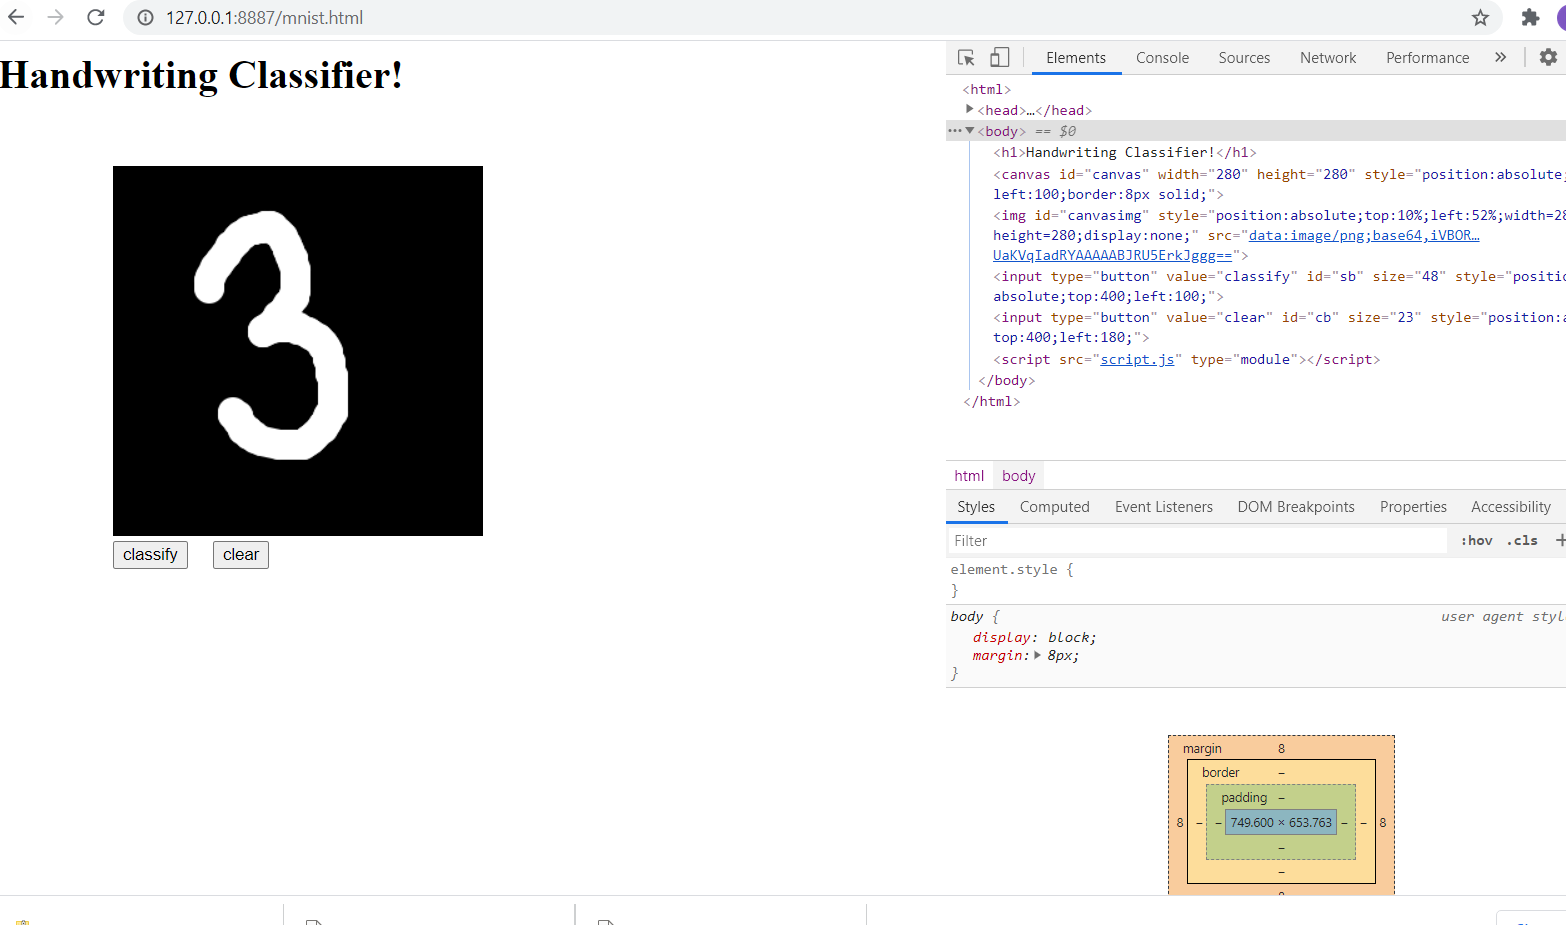

Ouput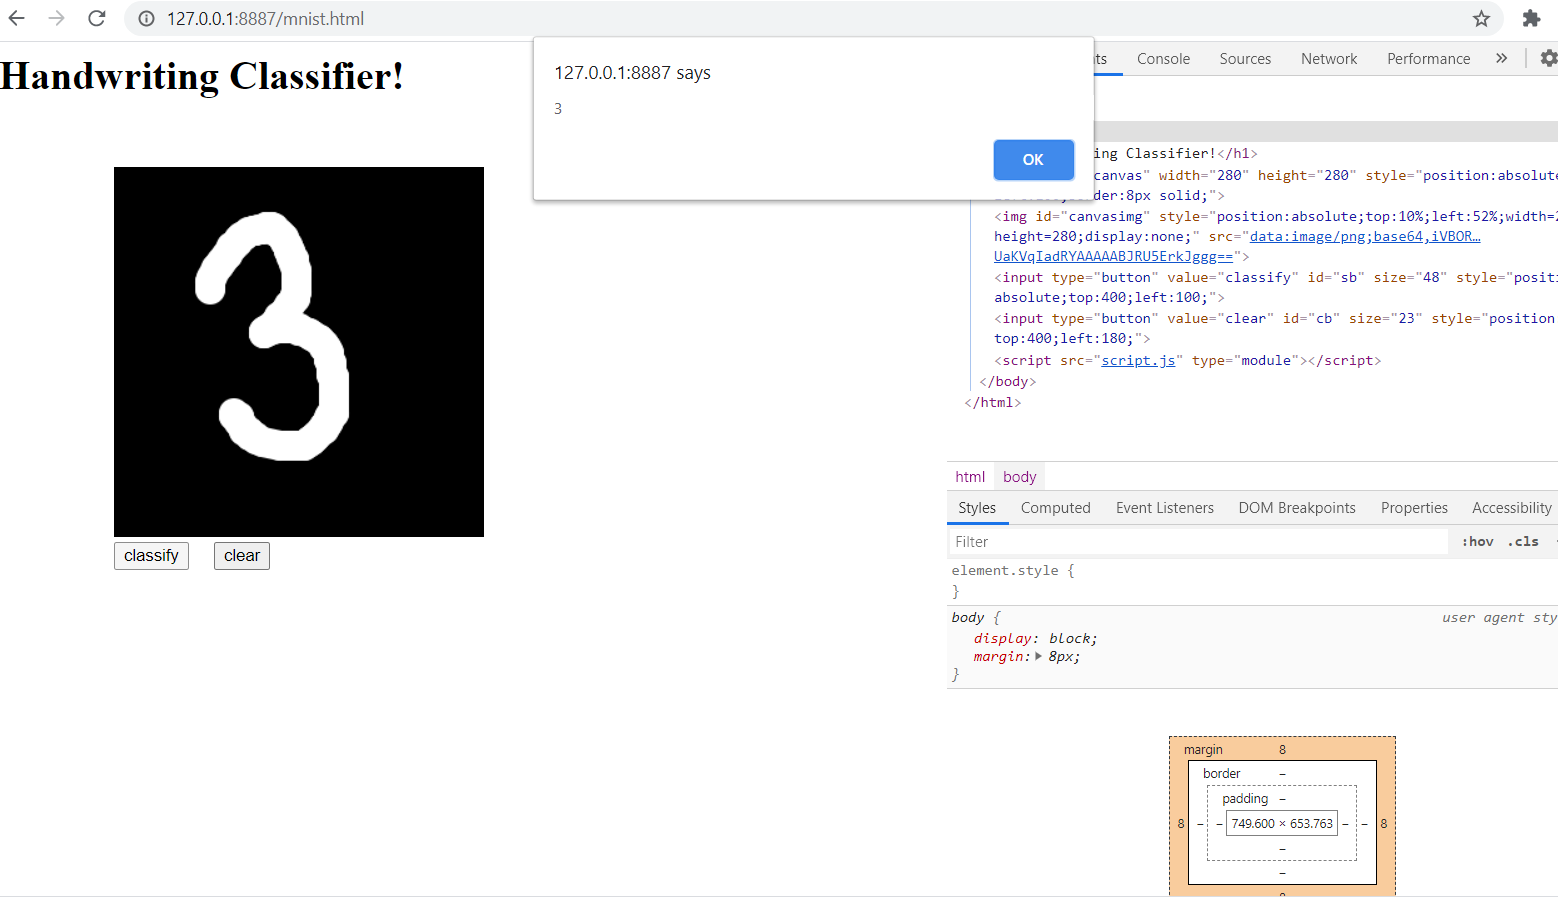